In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf 
import matplotlib.pyplot as plt
import pickle

import os
from PIL import Image
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Dropout, Lambda, Dense, Flatten, Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
#from sklearn.model_selection import train_test_split
from keras.utils.vis_utils import plot_model


# Import DATASET
## UTK-Face
https://susanqq.github.io/UTKFace/

https://www.kaggle.com/code/mohamadserawan/demographics-classifications/notebook

https://www.kaggle.com/code/asser37/mtl-age-gender-ethnicity

In [2]:
ds_path = 'C:/Users/Giorgia/0_thesis/UTKFace/'

[age] _ [gender] _ [race] _ [date&time].jpg

In [4]:
ds_tot_images = 0
for dirname, _, filenames in os.walk(ds_path):
    for filename in filenames:
        ds_tot_images += 1
        splitted = filename.split('_')
        age = splitted[0]
        gender = splitted[1]
        race = splitted[2]
        #print(os.path.join(dirname, filename))
        #break
print("Total number of images: ",ds_tot_images)

Total number of images:  23708


In [32]:
gender_mapper = {0: 'male', 1: 'female'}
ethnicity_mapper = {0: 'white', 1: 'black', 2: 'asian', 3: 'indian', 4: 'others'}

In [37]:
# Save DataFrame structure with all the images
df = pd.DataFrame(filenames, columns = ['filename'] )
df['filepath'] = df.filename.apply(lambda x: ds_path + x )
df['age'] = df.filename.apply(lambda x: int(x.split('_')[0]))
df['gender'] = df.filename.apply(lambda x: int(x.split('_')[1]))
df['ethnicity'] = df.filename.apply(lambda x: int(x.split('_')[-2]))

In [38]:
df.describe()

,age,gender,ethnicity
count,23708.000000,23708.000000,23708.000000
mean,33.303484,0.477349,1.269192
std,19.886112,0.499497,1.345556
min,1.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000
50%,29.000000,0.000000,1.000000
75%,45.000000,1.000000,2.000000
max,116.000000,1.000000,4.000000


In [39]:
df = df.replace({"gender": gender_mapper})
df = df.replace({"ethnicity": ethnicity_mapper})

In [40]:
df.head()

,filename,filepath,age,gender,ethnicity
0,100_0_0_20170112213500903.jpg.chip.jpg,C:/Users/Giorgia/0_thesis/UTKFace/100_0_0_2017...,100,male,white
1,100_0_0_20170112215240346.jpg.chip.jpg,C:/Users/Giorgia/0_thesis/UTKFace/100_0_0_2017...,100,male,white
2,100_1_0_20170110183726390.jpg.chip.jpg,C:/Users/Giorgia/0_thesis/UTKFace/100_1_0_2017...,100,female,white
3,100_1_0_20170112213001988.jpg.chip.jpg,C:/Users/Giorgia/0_thesis/UTKFace/100_1_0_2017...,100,female,white
4,100_1_0_20170112213303693.jpg.chip.jpg,C:/Users/Giorgia/0_thesis/UTKFace/100_1_0_2017...,100,female,white


### Observe the balance in the dataset of gender, age, and ethnicity 


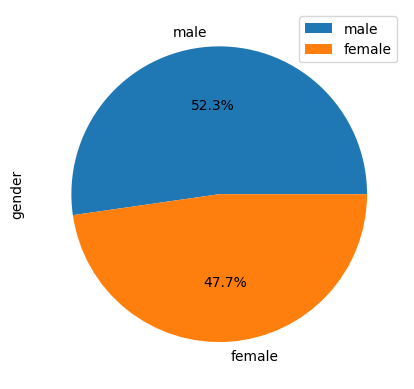

In [28]:
# gender
# 0:'male',1:'female'
#df['gender'].value_counts(dropna=False, normalize=True)

df['gender'].value_counts().plot.pie(autopct="%1.1f%%", labels=['male', 'female'])
plt.legend()

In [48]:
df['gender'].value_counts()

male      12391
female    11317
Name: gender, dtype: int64

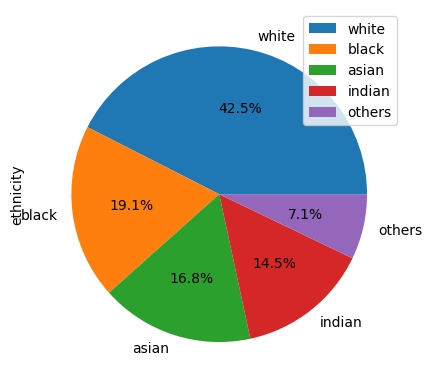

In [29]:
# ethnicity
# 0:'white', 1:'black',2: 'asian',3: 'indian', 4:'other'
#df['ethnicity'].value_counts(dropna=False, normalize=True)
df['ethnicity'].value_counts().plot.pie(autopct="%1.1f%%", labels=['white', 'black', 'asian', 'indian', 'others'])
plt.legend()

Text(0, 0.5, 'count')

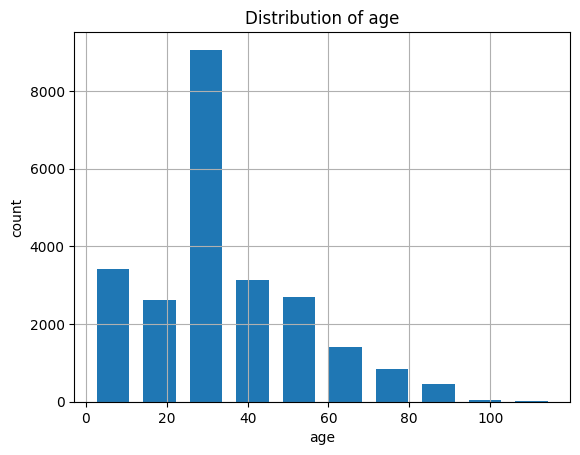

In [47]:
df['age'].hist(rwidth=0.7)
plt.title('Distribution of age')
plt.xlabel('age')
plt.ylabel('count')

In [30]:
# age
# https://www.researchgate.net/publication/228404297_Classification_of_Age_Groups_Based_on_Facial_Features/figures?lo=1

ranges = [range(0,3), range(3,13), range(13, 20), range(20, 30),
         range(30, 40), range(40, 50), range(50, 60), range(60, 70),
         range(70, 80), range(80, 90), range(90, 100), range(100,117)]

print("The percentage of images to the total in ")
count_age_ranges = []
for r in ranges:
    count_age_range = sum([len(df[df.age == j]) for j in r])
    count_age_ranges.append(count_age_range)
    print(r, "years:", round(count_age_range/ds_tot_images*100,2))

The percentage of images to the total in 
range(0, 3) years: 6.77
range(3, 13) years: 7.63
range(13, 20) years: 4.98
range(20, 30) years: 30.98
range(30, 40) years: 19.14
range(40, 50) years: 9.47
range(50, 60) years: 9.7
range(60, 70) years: 5.56
range(70, 80) years: 2.95
range(80, 90) years: 2.13
range(90, 100) years: 0.58
range(100, 117) years: 0.13


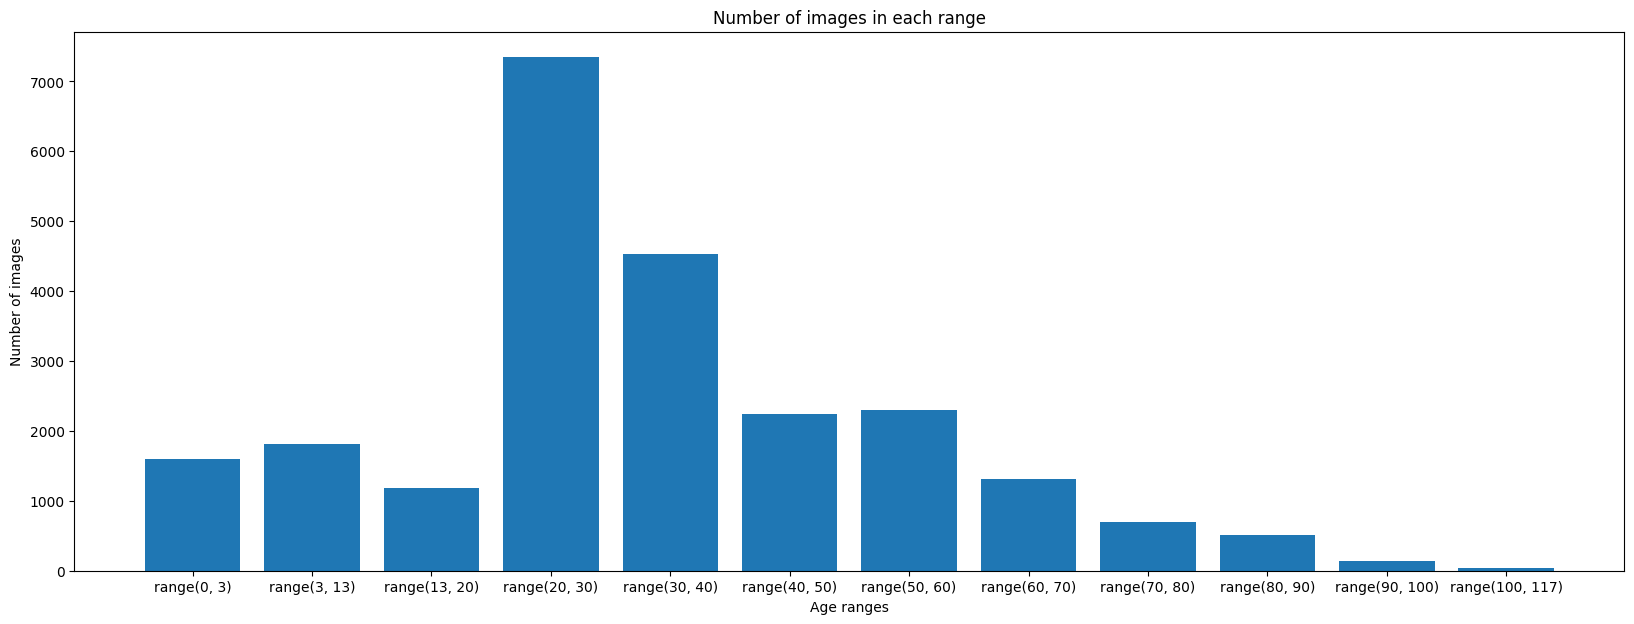

In [31]:
# Show a plot with the age distribution
x_pos = np.arange(len(count_age_ranges))
fig = plt.figure(dpi=100, figsize=(20, 7)) 
plt.bar(x_pos, count_age_ranges, align='center')
plt.xticks(x_pos, ranges)
plt.ylabel('Number of images')
plt.xlabel('Age ranges')
plt.title('Number of images in each range')
plt.show()

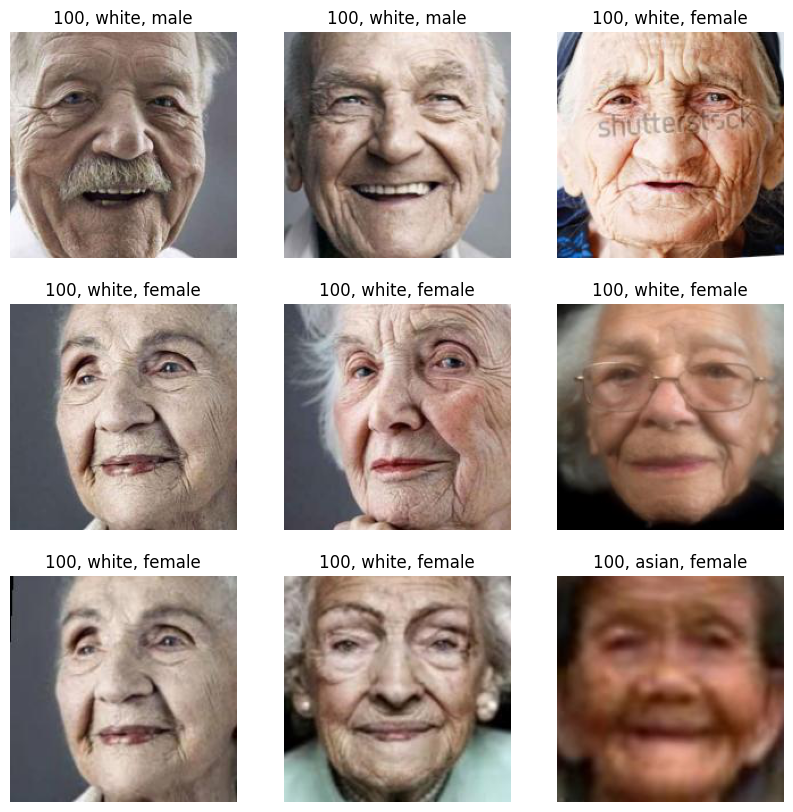

In [46]:
# Legend for image caption
IMG_WIDTH, IMG_HEIGHT = 96, 96
plt.figure(figsize=(10,10))
for i in range(9):
    sample = df.loc[i]
    plt.subplot(3,3,i+1)
    plt.axis('off')
    # with gender and ethnicity in number
    # plt.title('%i, %s, %s' % (sample.age,ethnicity_mapper[sample.ethnicity],gender_mapper[sample.gender]))
    # with gender and ethnicity in label
    plt.title('%i, %s, %s' % (sample.age, sample.ethnicity, sample.gender))
    plt.imshow(Image.open(ds_path + sample.filename))